# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 1. Простой анализ данных.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Latex

sns.set(style='whitegrid', font_scale=1.3)

---
### Задача 3.

Титаник был крупнейшим пассажирским судном в 1912—1913 годах. Во время первого рейса затонул в северной Атлантике, столкнувшись с айсбергом в ночь с 14 на 15 апреля 1912 года, при этом погибло 1502 из 2224 пассажиров и членов экипажа. Данные о пассажирах были собраны в таблицы, которые можно скачать с <a href="https://www.kaggle.com/c/titanic/data" target="_blank">Kaggle</a>. Эти данные часто используются в качестве обучающих в анализе данных.

На дополнительном занятии 10 февраля будет показан простой пример работы с датасетом Титаник. Сейчас ваша задача &mdash; на основе простого анализа предоставленных данных обучить несколько классификаторов для определения выживших, иначе говоря, получить некоторые приближенные правила определения, выжил пассажир или нет, а также сравнить эти правила по качеству приближения.

#### 1. Подготовка данных

Загрузим данные с помощью `pandas`.

In [3]:
data = pd.read_csv('train.csv', index_col=0)
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Разделим данные по строкам на две части случайным образом в соотношении 7:3. Первую часть мы будем называть *обучающей*, а вторую &mdash; *тестовой*.

In [4]:
train = data.sample(frac=0.7, random_state=1000)
test = data.drop(train.index)

Из каждой части оставим несколько признаков, с которыми мы будем работать, а также отдельно &mdash; целевой признак. Применим к обеим частям таблицы функцию ниже

In [5]:
features_columns = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
target_column = 'Survived'  # Целевой признак

def get_features_and_target(data):
    features = data[features_columns]
    target = data[target_column]
    return features, target

In [6]:
train_features, train_target = get_features_and_target(train)
test_features, test_target = get_features_and_target(test)

#### 2. Исследование

**Внимание.** Эта часть задачи должна выполняться *исключительно на обучающих данных*. За использование тестовых данных решение не будет оценено.

Проведем визуальный анализ данных чтобы понять, как различные признаки влияют на целевой.

Сначала посмотрим гистограммы каждого признака.

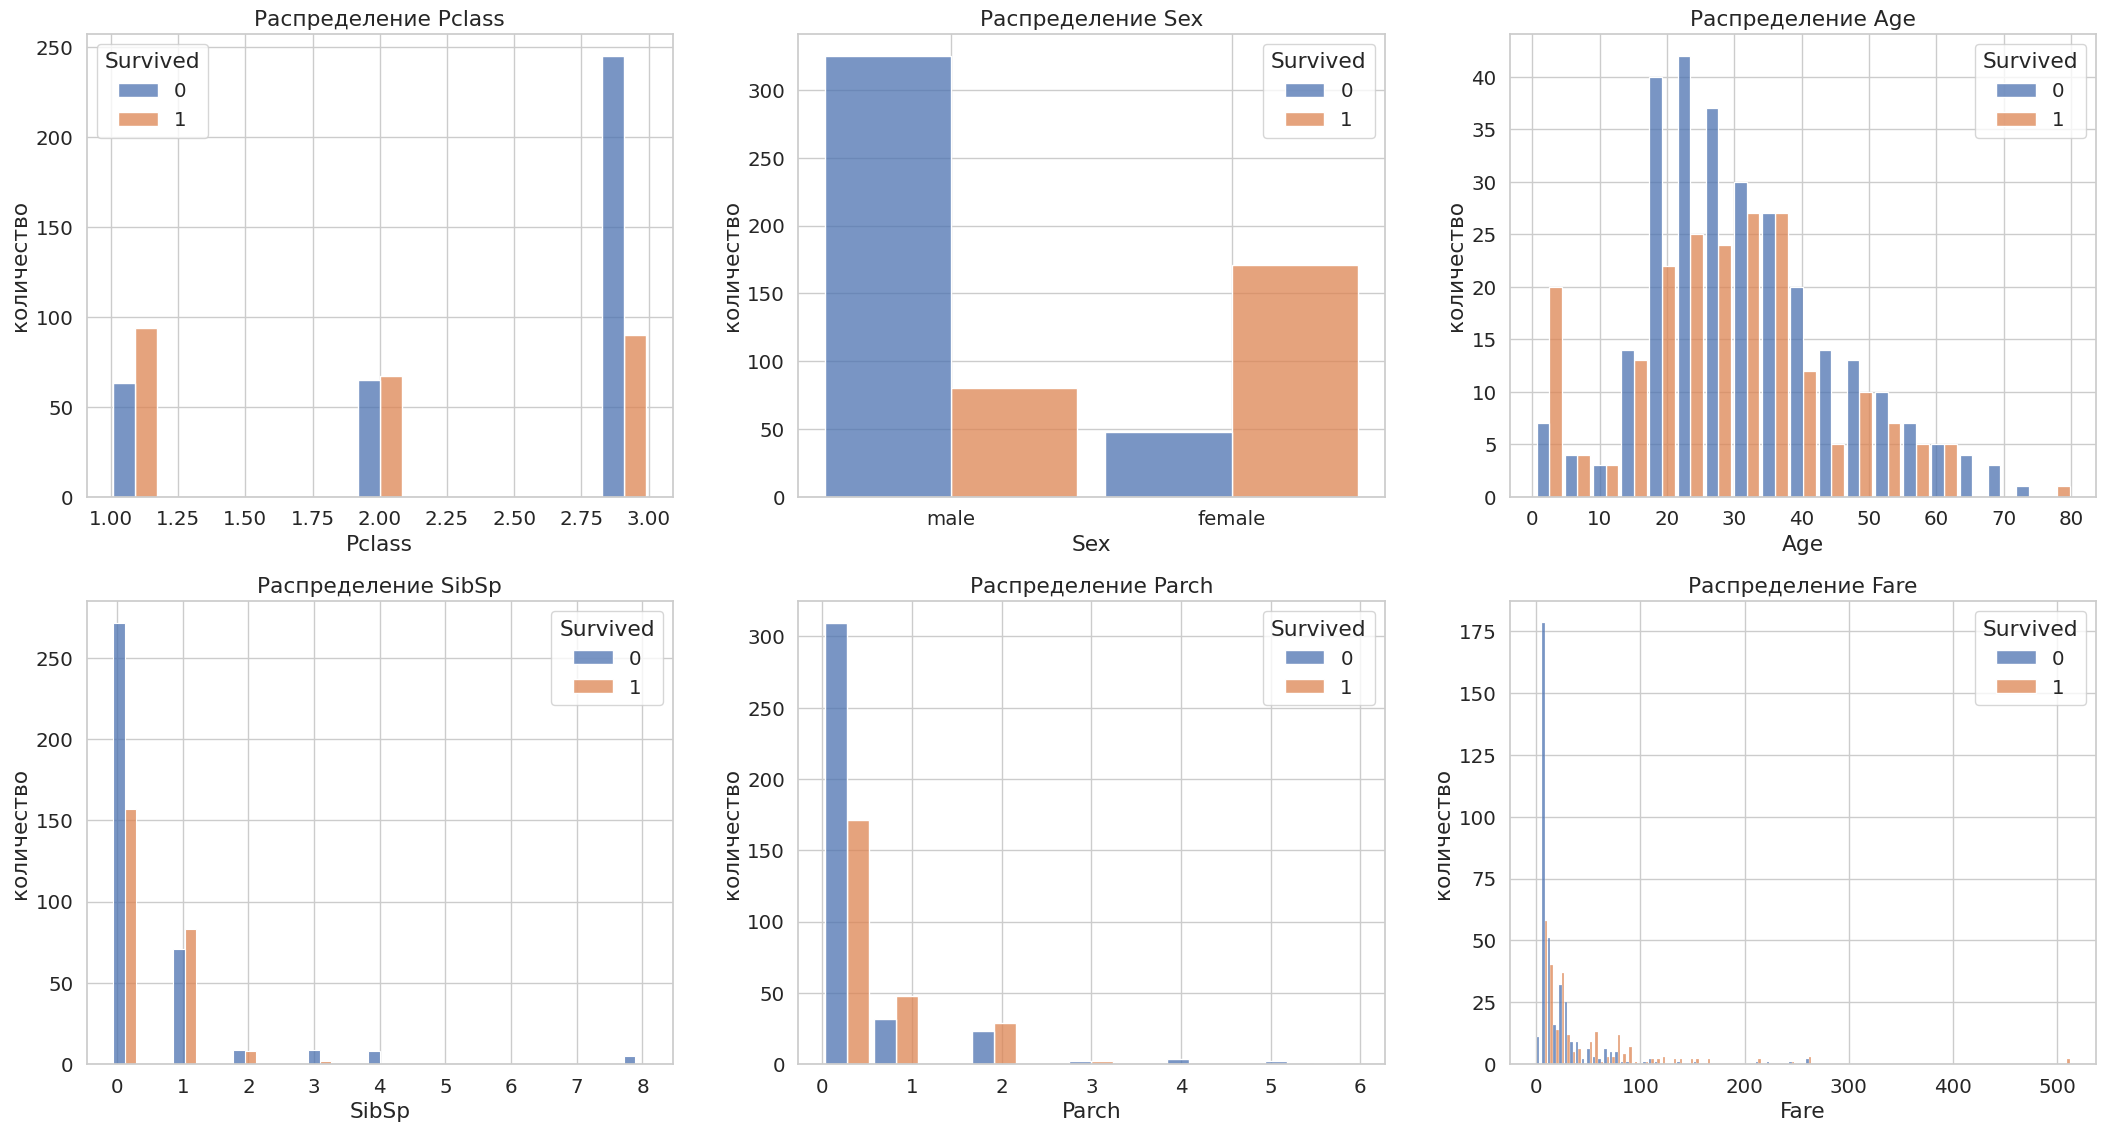

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(22, 12))
fig.tight_layout(pad=3)

for i in range(6):
    if (features_columns[i] == ("SibSp" or "Sex")):
        sns.histplot(data=train, x=features_columns[i], hue=target_column,
                     multiple='dodge', ax=ax[i // 3, i % 3], shrink = 1.5)
    else:
        sns.histplot(data=train, x=features_columns[i], hue=target_column, 
                 multiple='dodge', ax=ax[i // 3, i % 3], shrink = 0.9)
    
    ax[i // 3, i % 3].set(ylabel='количество',
                          title='Распределение ' + features_columns[i])
plt.show()

Последний график получился малоинформативным, поэтому переработаем его.

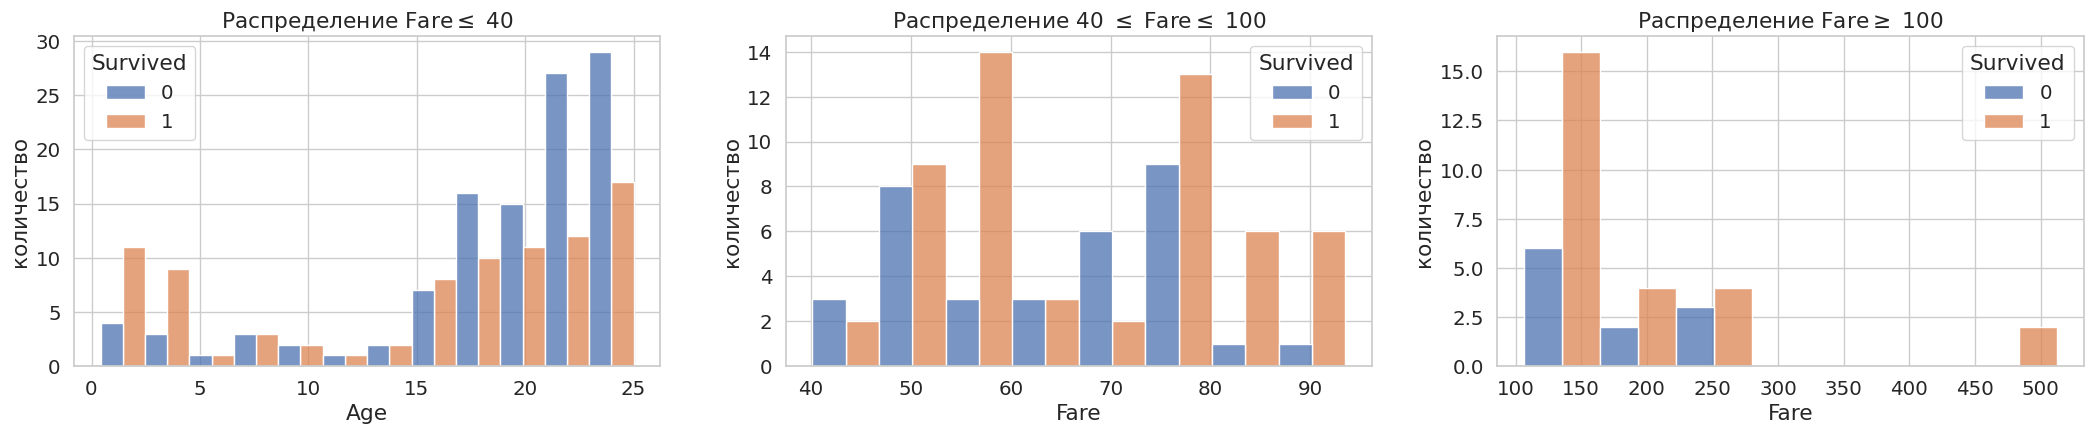

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(22, 5))
fig.tight_layout(pad=3)

sns.histplot(data=train[train["Age"] <= 25], x="Age", ax=ax[0],
             hue=target_column, multiple='dodge')
ax[0].set(ylabel='количество', title='Распределение Fare$\\leq$ 40')

sns.histplot(data=train[(train["Fare"] >= 40) & (train["Fare"] <= 100)] , x="Fare", ax=ax[1],
             hue=target_column, multiple='dodge')
ax[1].set(ylabel='количество', title='Распределение 40 $\\leq$ Fare$\\leq$ 100')

sns.histplot(data=train[train["Fare"] >= 100], x="Fare", ax=ax[2],
             hue=target_column, multiple='dodge')
ax[2].set(ylabel='количество', title='Распределение Fare$\\geq$ 100')

plt.show()

Проведем общий анализ гистограмм.
* **Pclass and Fare** Видно, что есть зависимость между социально-экономиеским статусом, ценой билета и выживаемостью. Наибольшее количество смертей приходится на P3: их каюты находились на нижних палубах. Pclass и Fare можно сказать, отражают одно и то же: чем выше стоимость билета, тем больше шанс выжить. Поэтому в дальнейшем будем ориентироваться только на данные *Fare*.
* **Sex** Большая часть мужин погибла, наилучшая выживаемость среди женщин.
* **Age** Наибольшая выживаемость среди детей ($0 \leq Age \leq 15$).
* **SibSp and Parch** Графики мало информативны, кроме того, что большинство ехали без членов семьи.

В итоге будем ориентироваться на 3 показателя `Fare, Sex, Age`.

p.s. <font color="red">Возможным минусом модели может быть то, что часть ячеек AGE пуста!</font>



In [9]:
print(f"{data.Age.count()} < {data.Name.count()}!") # столбец Name взят для примера, как полностью заполненный 

714 < 891!


#### 3. Классификация методом ближайшего соседа

Применим функцию поиска ближайших соседей для решения нашей текущей задачи. 

Реализуем функцию, которая для каждого объекта тестового набора данных найдет $k$ ближайших соседей из обучающего набора данных, и в качестве ответа возьмет наиболее часто встречающееся значение целевого признака среди найденных соседей. Соседей будем искать только среди объектов обучающего набора данных.

In [10]:
def distance(A: np.ndarray, B: np.ndarray) -> int:
    return np.sum((A-B)**2, axis=1)

In [11]:
def to_train_target(elem, train_features, train_target):
    return train_features[elem].train_target

In [12]:
def normalizing(features):
    features["Age"] = features["Age"] / features["Age"].mean()
    features["Fare"] = features["Fare"] / features["Fare"].mean()

In [13]:
def knn(features, train_features, train_target, k=1, normalization=False):
    '''
    Предсказание целевого признака для данных features -- pandas-таблица данных.
    на основе обучающего набора данных train_features, train_target.
    Возвращает pandas.Series с теми же индексами, что и у features.
    Число k -- количество соседей.
    '''
    if normalization:
        normalizing(features)
        normalizing(train_features)
    
    A = features[['Fare', 'Age']].to_numpy()
    B = train_features[['Fare', 'Age']].to_numpy()
    n, d = B.shape
    m = A.shape[0]
    B_mod = np.tile(B, (m, 1))
    A_mod = np.repeat(A, n, axis=0)
    C = distance(B_mod, A_mod)
    C = C.reshape((m, n)).argsort(axis=1)[:, 0:k]
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            C[i][j] = data.loc[C[i][j] + 1, train_target.name]
    return C.sum(axis=1) / k >= 0.5

Построим классификатор методом ближайшего соседа, используя только признаки `Age` и `Fare`. 

Какую метрику (функцию расстояния) вы при этом используете? Нужно ли предварительно что-то сделать с признаками?

$\textbf{Ответ:}$ для расчетов использовалась классическая *евклидова метрика*.

Посмотрим, насколько отличаются значения `Age` и `Fare`.

In [14]:
print(round(train_features["Age"].mean(), 3), round(train_features["Fare"].mean(), 3))

30.282 32.363


Видим, что в среднем, значения `Fare` больше, поэтому перед применением `kNN`, эти данные стоит отнормировать. *(см. реализацию)*

Как меняется результат классификации при другом количестве соседей? Рассмотрим, например, три различных нечетных значения количества соседей.

In [15]:
result1 = knn(test_features.copy(), train_features.copy(), train_target.copy(), 3, normalization=True)
result2 = knn(test_features.copy(), train_features.copy(), train_target.copy(), 7, normalization=True)
result3 = knn(test_features.copy(), train_features.copy(), train_target.copy(), 11, normalization=True)

print(f"Выжили {sum(result1)} человек.")
print(f"Выжили {sum(result2)} человек.")
print(f"Выжили {sum(result3)} человек.")

Выжили 78 человек.
Выжили 111 человек.
Выжили 47 человек.


Как можно было бы учесть другие признаки? Какие при этом могут возникнуть проблемы? 

Большая часть признаков, которые есть в датасете - категориальные, а для kNN, вообще говоря, непонятно как их учитывать. Как работает kNN? Оно меряет расстояние между точками. Поэтому их [признаки] надо перевести в численный вид и отнормировать. Но как быть, например, с `Sex`, который дает +1 под корень евклидовой метрики?
* если не нормировать, то важность этой категории может сильно уменьшиться, чего мы не хотим.
* если нормировать, то вопрос как. Если взять *min-max* нормировку, то признак пола она никак не изменит, когда как другие признаки попадут на отрезок [0, 1]. А это приведет к тому, что пол будет слишком сильно влиять на предсказание, чего мы тоже не хотим.

Возможно, стоило бы ввести какой-то гиперпараметр, решающий данную проблему.

#### 4. Классификация логическими правилами

На основе выше проведенного исследования предложите два разных правила в виде решающего дерева, пример которого можете посмотреть в презентации с первой лекции (классификация котиков). Никакие статистические методы использовать не требуется, только логику и графики.

В данной задаче достаточно, если первое дерево будет иметь максимальную глубину 2, а второе &mdash; глубину 1, и при этом не является поддеревом первого. *Примечание*: дерево из одного листа имеет глубину 0.

**Дерево 1:**

Чем выше стоимость билета, тем лучше расположение каюты. Кроме того, даже если билет дешевый, а человек - ребенок, тогда его шанс спастись всё равно велик. Тогда построим следующее дерево:
* Цена билета $\geq 50$? Если да, то смотрим на возраст, если нет, то погиб.
* Возраст $\leq 15$? Если да, то выжил, если нет - погиб.

**Дерево 2:**

Одним из главных показателей выживаемости является пол. Проведем классификацию так: если женщина, то выжила, если мужчина - нет. Это подтверждается построенными гистограммами, кроме того, логично предположить, что детей и женщин спасали в первую очередь.

Реализуем деревья.

Почему выбраны именно такие границы в Дереве 1 смотрите `5. Качество`.

In [16]:
def tree1(features):
    '''
    Предсказание целевого признака для данных features -- pandas-таблица данных.
    Возвращает pandas.Series с теми же индексами, что и у features.
    '''
    low_cost = features.Fare <= 50
    high_cost = 1 - low_cost
    child = features.Age <= 15
    predicted = high_cost.values | (low_cost.values & child.values)
    return predicted

def tree2(features):
    '''
    Предсказание целевого признака для данных features -- pandas-таблица данных.
    Возвращает pandas.Series с теми же индексами, что и у features.
    '''
    predicted = features.Sex == 'female'
    return predicted

#### 5. Качество

Вспомним, что у нас имеется тестовая часть выборки. Самое время ее использовать для того, чтобы оценить, насколько хорошими получились деревья. Предложим следующий критерий оценки точности.

**Критерий:**

точность $ = \frac{(\text{верных предсказаний})}{(\text{всех предсказаний})}$

Реализуем данный критерий.

In [17]:
def criteria(target, predicted):
    '''
    Вычисление критерия качества для предсказания predicted, 
    если истинные значения -- target.
    Возвращает одно вещественное число.
    '''
    crit = (target == predicted).sum() / target.shape[0]
    return crit

Оценим качество построенных ранее моделей (два дерева, kNN), используя предложенный критерий.

In [18]:
quality_tree1 = round(criteria(test.Survived, tree1(test)), 3)
quality_tree2 = round(criteria(test.Survived, tree2(test)), 3)
print(f"Качество предсказания tree1 = {quality_tree1}\nКачество предсказания tree2 = {quality_tree2}")

Качество предсказания tree1 = 0.723
Качество предсказания tree2 = 0.768


**Замечание**. Через несколько итераций приходим к тому, что лучшие границы 
* для стоимости билета $Fare = 50$
* для возраста ребенок/взрослый $Age = 15$

Посчитаем значение предложенного ранее критерия качества для метода ближайшего соседа для значений $k$ от 1 до 10. Построим график зависимости критерия качества от $k$.

/tmp/ipykernel_29230/3552365851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["Age"] = features["Age"] / features["Age"].mean()
/tmp/ipykernel_29230/3552365851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["Fare"] = features["Fare"] / features["Fare"].mean()
/tmp/ipykernel_29230/3552365851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

/tmp/ipykernel_29230/3552365851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["Age"] = features["Age"] / features["Age"].mean()
/tmp/ipykernel_29230/3552365851.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features["Fare"] = features["Fare"] / features["Fare"].mean()
/tmp/ipykernel_29230/3552365851.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

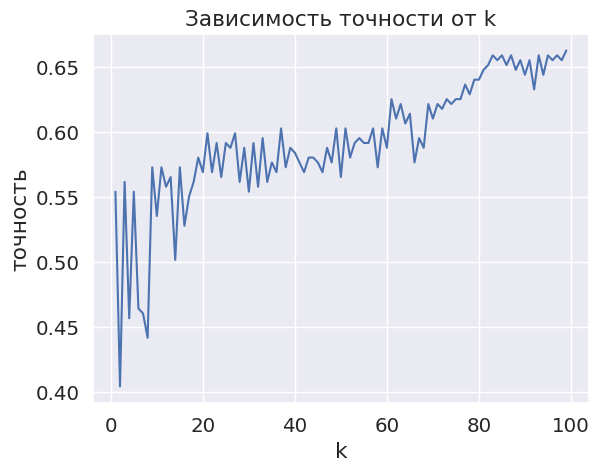

In [19]:
x = []
y = []

for i in range(1, 100):
    predict = knn(test_features, train_features, train_target, k=i, normalization=True)
    acc = criteria(np.array(test.Survived), predict)
    x.append(i)
    y.append(acc)

with sns.axes_style("darkgrid"):
    plt.xlabel('k')
    plt.ylabel('точность') 
    plt.title('Зависимость точности от k')
    plt.plot(x, y)
    plt.show()

Видим, что малые значения k (k < 10) не позволяют дать объективное предсказание: судя по пикам предсказание близко к случайному. Плюс минус равномерное зачение достигается в промежутке $40\le k\le 60$. При дальнейшем увеличении k мы смотрим практически все данные датасета.

#### 6. Выводы

Оба способа предсказания получили точность $\geq 0.5$, что лучше чем при угадывании значения бинарной случайной величины. Кроме того большую точность получило предсказывание по полу в решающем дереве. Это говорит о том, что пол - наиболее удачный критерий для классификации. 

Предсказание с помощью метода `kNN` имеет ряд тонкостей и ограничений в применении. Об этом надо помнить. С ней мы 
* достигли точности $\geq 0.6$
* выявили оптимальное значение k


В результате получили три главные характеристики:
* если женщина, то скорее всего выживет
* если ребенок, то скорее всего выживет
* если богатый человек, то скорее всего выживет